# Week 5 - Semantic & Influence Networks

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

For this assignment, I used dataset collected from Medium, an online publishing platform where uesrs can publish articles or blogs while other users can read and "clap" the article if they think it's helpful. 
The dataset is found through Kaggle. It contains articles, their title, number of claps it has received, their links and their reading time.

In [2]:
# Load the dataset
medium_df = pandas.read_csv('medium.csv')
medium_df.head()

author claps  reading_time  \
0        Justin Lee  8.3K            11   
1       Conor Dewey  1.4K             7   
2  William Koehrsen  2.8K            11   
3      Gant Laborde  1.3K             7   
4  Emmanuel Ameisen   935            11   

                                                link  \
0  https://medium.com/swlh/chatbots-were-the-next...   
1  https://towardsdatascience.com/python-for-data...   
2  https://towardsdatascience.com/automated-featu...   
3  https://medium.freecodecamp.org/machine-learni...   
4  https://blog.insightdatascience.com/reinforcem...   

                                               title  \
0  Chatbots were the next big thing: what happene...   
1  Python for Data Science: 8 Concepts You May Ha...   
2  Automated Feature Engineering in Python – Towa...   
3  Machine Learning: how to go from Zero to Hero ...   
4  Reinforcement Learning from scratch – Insight ...   

                                                text  
0  Oh, how the headlines blared:\nChatbots were T...  
1  If you’ve ever found yourself looking up the s...  
2  Machine learning is increasingly moving from h...  
3  If your understanding of A.I. and Machine Lear...  
4  Want to learn about applied Artificial Intelli...

In [3]:
# Tokenize and normalize the text data
medium_df['tokenized_sents'] = medium_df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
medium_df['normalized_sents'] = medium_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

### Document-to-Document Network

In [4]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

# Function to find words that co-occur in the same sentences
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        union = set(sent) | stopWords
        intersection = set(sent) & stopWords
        words |= (union - intersection)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [5]:
# First, build a graph based on word cooccurences in the first 100 medium articles
g = wordCooccurrence(medium_df['normalized_sents'][:100].sum())

In [6]:
# Total number of vertices and edges
print("total number of vertices:", len(g.nodes))
print("total number of edges:", len(g.edges))

total number of vertices: 7806
total number of edges: 257941


In [7]:
# The adjacency matrix of cleaned word
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
# Build a two-mode network graph
import sklearn.feature_extraction
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

In [9]:
# Fit the model
mediumVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
mediumVects_incidence = mediumVectorizer.fit_transform(medium_df['text'][:100])
mediumVects_incidence.shape

(100, 7645)

In [10]:
# Turn the incidence matrix into a network.
g_2mode = nx.Graph()

g_2mode.add_nodes_from((mediumVectorizer.get_feature_names()[i] for i in range(mediumVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(mediumVects_incidence.shape[0]), bipartite = 'doc')

g_2mode.add_edges_from(((d, mediumVectorizer.get_feature_names()[w], {'weight' : mediumVects_incidence[d, w]}) for d, w in zip(*mediumVects_incidence.nonzero())))

In [11]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 7745
Number of edges: 42155
Average degree:  10.8857


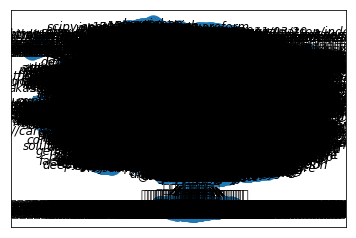

In [12]:
# Plot the bipartite network
nx.draw_networkx(g_2mode)

Without filtering, the graph did not bring any insights. So we transform the two-mode network into one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share.

In [13]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [14]:
gDoc = contractNetwork(g_2mode, 'doc')

In [15]:
# Look at the document-to-document network
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


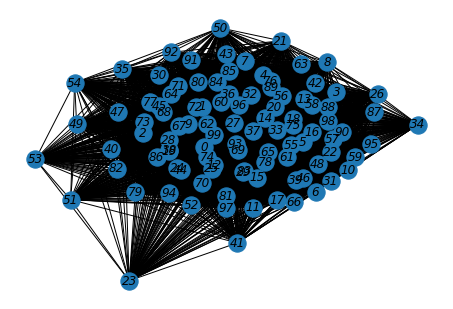

In [16]:
# Construct a visualization
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()})

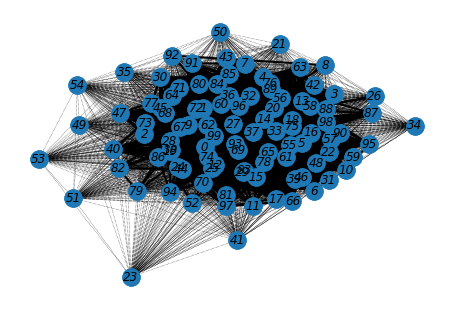

In [17]:
# Draw the graph with high and low edges distinguished
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 23 and 41 are on the outside, while 27 and 19 are at the center. We can look at them:

In [18]:
#23
print(len(medium_df.iloc[23]['text']),"words:","\n",medium_df.iloc[23]['text'].strip().replace('  ', '\n'))

1413 words: 
 这一阵为了工作上的关系,花了点时间学习了一下LDA算法,说实话,对于我这个学CS而非学数学的人来说,除了集体智慧编程这本书之外基本没怎么看过机器学习的人来说,一开始还真是摸不太到门道,前前后后快要四个月了,算是基本了解了这个算法的实现,记录一下,也供后来人快速入门做个参考。
一开始直接就下了Blei的原始的那篇论文来看,但是看了个开头就被Dirichlet分布和几个数学公式打倒,然后因为专心在写项目中的具体的代码,也就先放下了。但是因为发现完全忘记了本科学的概率和统计的内容,只好回头去看大学时候概率论的教材,发现早不知道借给谁了,于是上网买了本,花了几天时间大致回顾了一遍概率论的知识,什么贝叶斯全概率公式,正态分布,二项分布之类的。后来晚上没事儿的时候,去水木的AI版转了转,了解到了Machine Learning的圣经PRML,考虑到反正也是要长期学习了,搞了电子版,同时上淘宝买了个打印胶装的版本。春节里每天晚上看一点儿,扫了一下前两章,再次回顾了一下基本数学知识,然后了解了下贝叶斯学派那种采用共轭先验来建模的方式。于是再次尝试回头去看Blei的那篇论文,发现还是看不太懂,于是又放下了。然后某天Tony让我准备准备给复旦的同学们share一下我们项目中LDA的使用,为了不露怯,又去翻论文,正好看到Science上这篇Topic Models Vs. Unstructured Data的科普性质的文章,翻了一遍之后,再去PRML里看了一遍Graphic Models那一张,觉得对于LDA想解决的问题和方法了解了更清楚了。之后从search engine里搜到这篇文章,然后根据推荐读了一部分的Gibbs Sampling for the Uninitiated。之后忘了怎么又搜到了Mark Steyvers和Tom Griffiths合著的Probabilistic Topic Models,在某个周末往返北京的飞机上读完了,觉得基本上模型训练过程也明白了。再之后就是读了一下这个最简版的LDA Gibbs Sampling的实现,再回过头读了一下PLDA的源码,基本上算是对LDA有了个相对清楚的了解。
这样前前后后,也过去了三个月,其实不少时间都是浪费掉的,比如Blei的论文在没有任何相关知识的情况下一开始读了好几次,都没读完而且得到到信息

In [19]:
#27
print(len(medium_df.iloc[27]['text']),"sample words:","\n",medium_df.iloc[27]['text'][:5000].strip().replace('  ', '\n'))

44527 sample words: 
 This post outlines a formalization of what Nick Bostrom calls “indirect normativity.” I don’t think it’s an adequate solution to the AI control problem; but to my knowledge it was the first precise specification of a goal that meets the “not terrible” bar, i.e. which does not lead to terrible consequences if pursued without any caveats or restrictions. The proposal outlined here was sketched in early 2012 while I was visiting FHI, and was my first serious foray into AI control.
When faced with the challenge of writing down precise moral principles, adhering to the standards demanded in mathematics, moral philosophers encounter two serious difficulties:
In light of these difficulties, a moral philosopher might simply declare: “It is not my place to aspire to mathematical standards of precision. Ethics as a project inherently requires shared language, understanding, and experience; it becomes impossible or meaningless without them.”
This may be a defensible philosop

From the results above, it is not suprising that the outside ariticle has much less words compared the number of words of two central articles.

### Word-to-Word Network

In [20]:
# Look at the word-to-word network by documents
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 7645
Number of edges: 4595792
Average degree: 1202.3001


In [21]:
# Reduce the number of words to a manageable size
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.3132994269540483

In [22]:
g = wordCooccurrence(medium_df['normalized_sents'][:100].sum())

# drop all the edges with weight below 25
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])
g.remove_nodes_from(list(nx.isolates(g)))

In [23]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [24]:
giant = max(connected_component_subgraphs(g), key=len) 
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 184
Number of edges: 512
Average degree:   5.5652


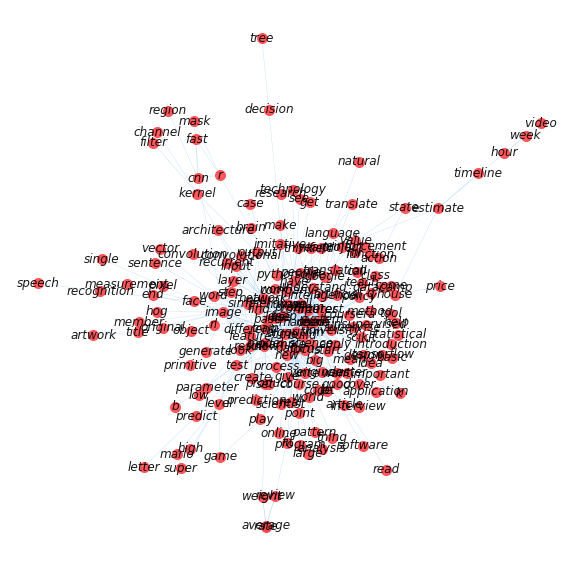

In [25]:
# Visualize
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [26]:
# Find communities in graphs
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))
c

[frozenset({'action',
            'algorithm',
            'analysis',
            'application',
            'apply',
            'architecture',
            'article',
            'artificial',
            'artwork',
            'average',
            'b',
            'base',
            'basic',
            'big',
            'brain',
            'build',
            'call',
            'case',
            'channel',
            'class',
            'cluster',
            'cnn',
            'code',
            'come',
            'company',
            'computer',
            'convolution',
            'convolutional',
            'course',
            'coursera',
            'cover',
            'create',
            'datacamp',
            'datum',
            'decision',
            'deep',
            'design',
            'different',
            'end',
            'engineer',
            'estimate',
            'example',
            'face',
            'fast',
            'fe

In [27]:
# Remove the above words that show up in many documents
giant = nx.Graph(giant)
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 184
Number of edges: 512
Average degree:   5.5652


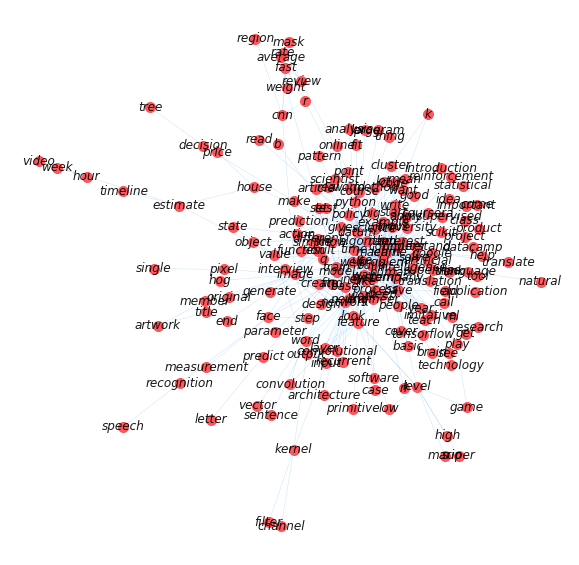

In [28]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [29]:
# Find cliques - completely connected sets of nodes
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

learn, datum, machine, have, use, like, neural


In [30]:
# Subgraph of 'machine'
learningNeighbors = giant.neighbors('machine')
g_learning = giant.subgraph(learningNeighbors)
print(nx.info(g_learning))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 171
Average degree:   9.5000


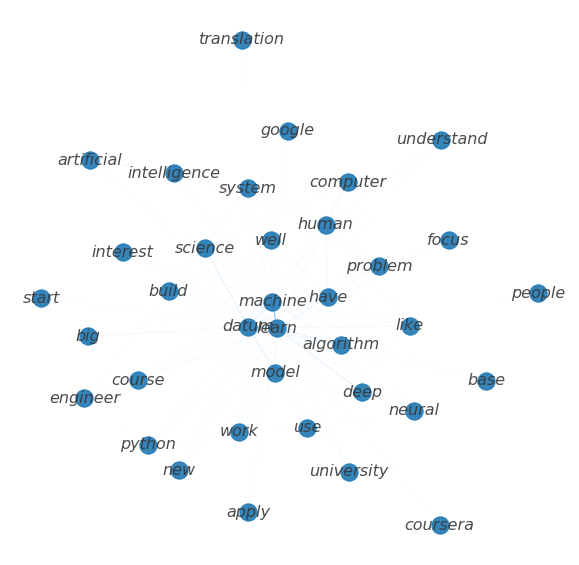

In [31]:
layout_learning = nx.spring_layout(g_learning, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_learning.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_learning.edges(data = True)))
nx.draw(g_learning, ax = ax, pos = layout_learning, labels = {n:n for n in g_learning.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_learning.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [32]:
learningNeighbors = gWord.neighbors('machine')
learningNeighborsPlus1 = set(learningNeighbors)
for n in learningNeighbors:
    learningNeighborsPlus1 |= set(giant.neighbors(n))

In [33]:
g_learning2 = giant.subgraph(learningNeighborsPlus1)
print(nx.info(g_learning2))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 476
Average degree:   5.2022


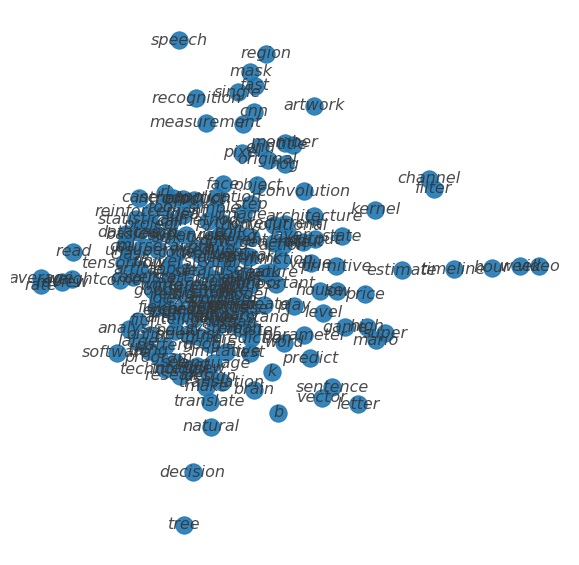

In [34]:
layout_learn = nx.spring_layout(g_learning2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_learn = nx.eigenvector_centrality(g_learning2)
maxC = max(centralities_learn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_learning2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_learning2.edges(data = True)))
nx.draw(g_learning2, ax = ax, pos = layout_learn, labels = {n:n for n in g_learning2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_learning2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

Through analyzing the structure of words, I find that dropping all the edges below certain weight and all the isolates can produce more interpretable semantic structures. The core cliques in this dataset include learn, datum, machine, have, use, like, and neural. From this word to word network, I find removing isloates also helpful to simlify the network. According to the results above, we can find "learning", "model", "machine" are quite central in this network and it is in line with our expectation.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

### Degree Centrality

In [35]:
dcentralities = nx.degree_centrality(giant)
dcentralities['machine']

0.20218579234972678

In [36]:
max(dcentralities.items(), key = lambda x : x[1])

('learn', 0.5191256830601093)

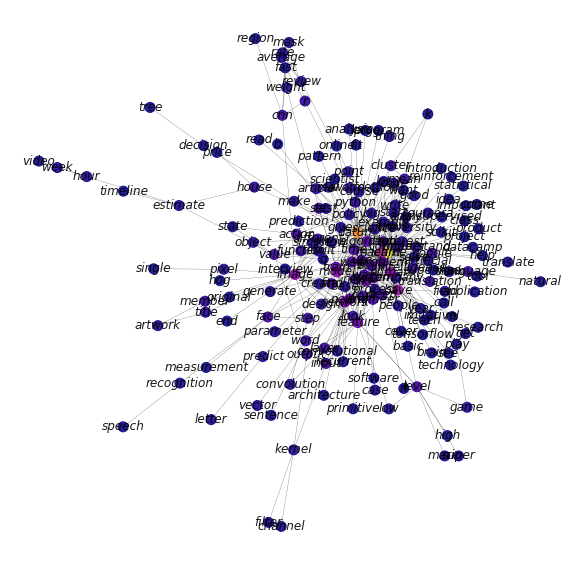

In [37]:
# Color and size the nodes by degree
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

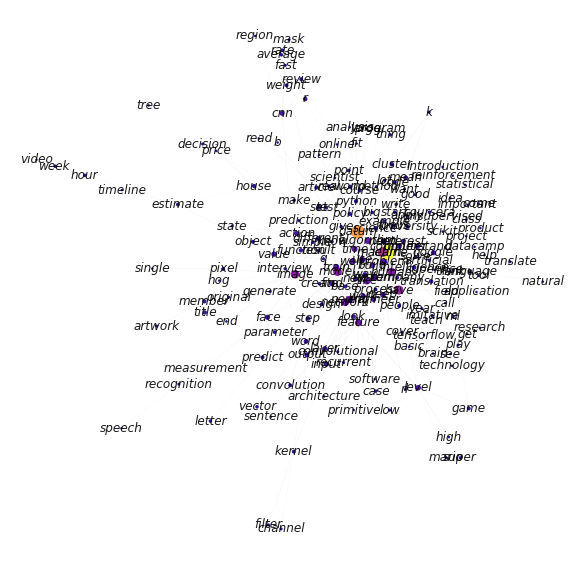

In [38]:
# Visualize to represent degree centrality and age weight
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

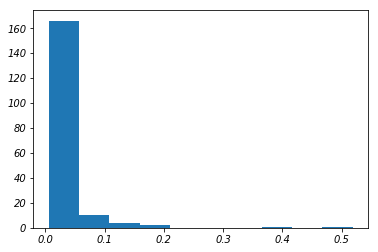

In [39]:
# Distribution of degree centrality
plt.hist(list(dcentralities.values()))
plt.show()

In [40]:
# Top 10 words in degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('learn', 0.5191256830601093),
 ('datum', 0.39344262295081966),
 ('machine', 0.20218579234972678),
 ('have', 0.16939890710382513),
 ('image', 0.14754098360655737),
 ('model', 0.14754098360655737),
 ('human', 0.14207650273224043),
 ('network', 0.12021857923497267),
 ('like', 0.09836065573770492),
 ('neural', 0.09289617486338798)]

In [41]:
# Bottom 10 words in degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('supervise', 0.00546448087431694),
 ('price', 0.00546448087431694),
 ('tensorflow', 0.00546448087431694),
 ('tool', 0.00546448087431694),
 ('application', 0.00546448087431694),
 ('get', 0.00546448087431694),
 ('ml', 0.00546448087431694),
 ('pattern', 0.00546448087431694),
 ('idea', 0.00546448087431694),
 ('unsupervised', 0.00546448087431694)]

### Betweenness Centrality

In [42]:
b_centralities = nx.betweenness.betweenness_centrality(giant)
b_centralities['machine']

0.03105177686094411

In [43]:
max(b_centralities.items(), key = lambda x : x[1])

('learn', 0.4863790145040708)

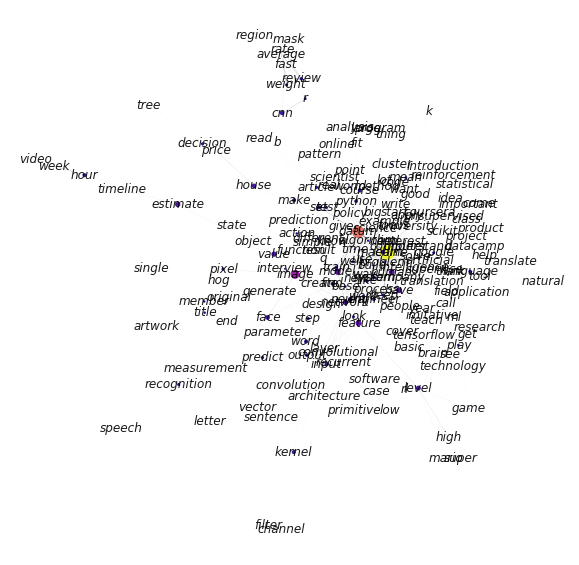

In [44]:
# Color and size the nodes by betweenness centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(b_centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [b_centralities[n] / maxC for n in giant.nodes],
        node_size = [b_centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

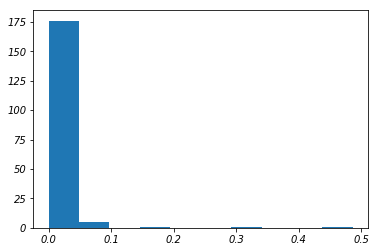

In [45]:
# The distribution of betweenness centrality
plt.hist(list(b_centralities.values()))
plt.show()

In [46]:
# Top 10 words in terms of betweenness centrality
sorted(b_centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('learn', 0.4863790145040708),
 ('datum', 0.3014674574739223),
 ('image', 0.15210607087475342),
 ('model', 0.06536708760706492),
 ('feature', 0.05959015872794826),
 ('have', 0.05848532318194717),
 ('human', 0.054419729371652785),
 ('network', 0.04922204232874823),
 ('estimate', 0.04363578134069937),
 ('value', 0.042344016070370305)]

In [47]:
# Bottom 10 words in terms of betweenness centrality
sorted(b_centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('get', 0.0),
 ('interest', 0.0),
 ('ml', 0.0),
 ('case', 0.0),
 ('pattern', 0.0),
 ('mask', 0.0),
 ('idea', 0.0),
 ('parameter', 0.0),
 ('unsupervised', 0.0),
 ('artificial', 0.0)]

### Closeness Centrality

In [49]:
c_centralities = nx.closeness_centrality(giant)
c_centralities['machine']

0.46329113924050636

In [55]:
max(c_centralities.items(), key = lambda x : x[1])

('learn', 0.5960912052117264)

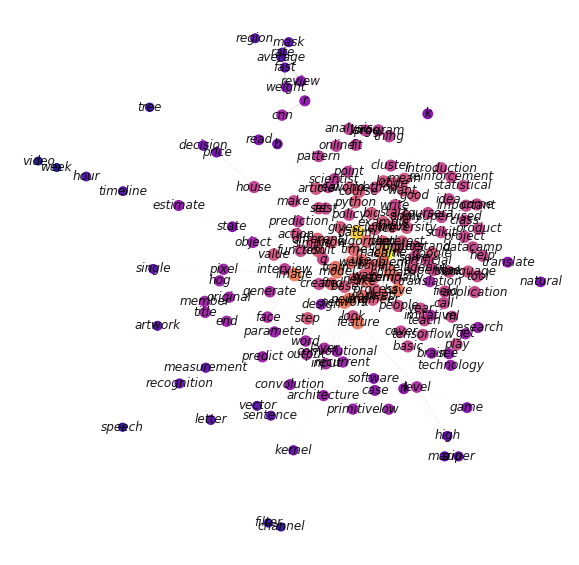

In [56]:
# Color and size the nodes by closeness centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(c_centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [c_centralities[n] / maxC for n in giant.nodes],
        node_size = [c_centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

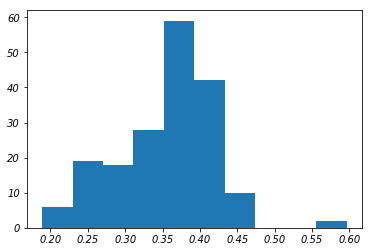

In [57]:
# The distribution of betweenness centrality
plt.hist(list(c_centralities.values()))
plt.show()

In [58]:
# Top 10 words in terms of betweenness centrality
sorted(c_centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('learn', 0.5960912052117264),
 ('datum', 0.5562310030395137),
 ('image', 0.46446700507614214),
 ('machine', 0.46329113924050636),
 ('network', 0.4552238805970149),
 ('model', 0.45185185185185184),
 ('have', 0.45073891625615764),
 ('feature', 0.45073891625615764),
 ('neural', 0.44963144963144963),
 ('human', 0.4430992736077482)]

In [59]:
# Bottom 10 words in terms of betweenness centrality
sorted(c_centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('rate', 0.2340153452685422),
 ('average', 0.2340153452685422),
 ('hour', 0.23252858958068615),
 ('timeline', 0.23135271807838179),
 ('tree', 0.21378504672897197),
 ('filter', 0.20446927374301677),
 ('channel', 0.20446927374301677),
 ('speech', 0.2010989010989011),
 ('week', 0.18885448916408668),
 ('video', 0.18885448916408668)]

### Eigenvector Centrality

In [60]:
e_centralities = nx.eigenvector_centrality(giant)
e_centralities['machine']

0.25808631655953546

In [61]:
max(e_centralities.items(), key = lambda x : x[1])

('learn', 0.42142768394127816)

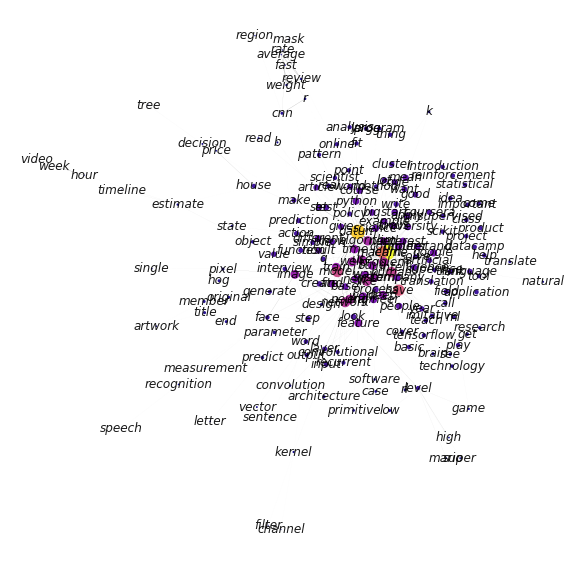

In [62]:
# Color and size the nodes by eigenvector centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(e_centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [e_centralities[n] / maxC for n in giant.nodes],
        node_size = [e_centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

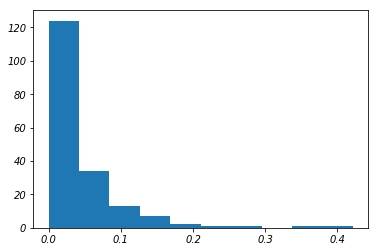

In [63]:
# The distribution of eigenvector centrality
plt.hist(list(e_centralities.values()))
plt.show()

In [64]:
# Top 10 words in terms of eigenvector centrality
sorted(e_centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('learn', 0.42142768394127816),
 ('datum', 0.37549035225054855),
 ('machine', 0.25808631655953546),
 ('have', 0.22182109235700767),
 ('model', 0.19983026454773073),
 ('human', 0.18601456972008176),
 ('like', 0.16718267657979966),
 ('network', 0.16675272741794478),
 ('neural', 0.15241152111197678),
 ('problem', 0.15172655779016164)]

In [65]:
# Bottom 10 words in terms of eigenvector centrality
sorted(e_centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('rate', 0.0004705515441248725),
 ('average', 0.0004705515441248725),
 ('hour', 0.00023642230447887982),
 ('timeline', 0.0002346923241558841),
 ('filter', 0.0002075003982439894),
 ('channel', 0.0002075003982439894),
 ('tree', 0.00011942450569922542),
 ('speech', 8.4977757580746e-05),
 ('week', 1.4969787656348886e-05),
 ('video', 1.4078254557347889e-05)]

### Filter Network by Centrality

In [66]:
# Function to filter out the network by a type of centrality 
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [67]:
giant_filtered35 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=35)
print(nx.info(giant_filtered35))

Total number of nodes(after filtering) in the graph is 35
Name: 
Type: Graph
Number of nodes: 35
Number of edges: 140
Average degree:   8.0000


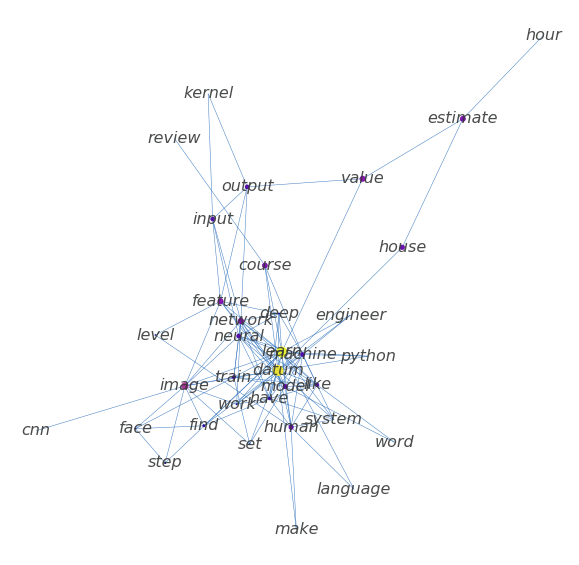

In [68]:
layout_giant_filtered35 = nx.spring_layout(giant_filtered35, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant35 = nx.betweenness_centrality(giant_filtered35)
maxC = max(centralities_giant35.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered35, ax = ax, pos = layout_giant_filtered35, labels = {n: n for n in giant_filtered35.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant35[n] / maxC for n in giant_filtered35.nodes],
        node_size = [centralities_giant35[n] / maxC * 100 for n in giant_filtered35.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [69]:
# Density
nx.density(giant)

0.030411023996198622

In [70]:
# Average degree per code
np.mean([v for w,v in nx.degree(giant)])

5.565217391304348

In [71]:
# Diameter
nx.diameter(giant)

8

Based on the analysis on centrality, I found 'learn' appears to be the most centralized word in the network, as it has the highest degree, betweenness centrality, closeness centrality and eigenvector centrality. Generally speaking, different centraliaty measures give similar most central words and least central words, but slight different remains. The most central words tend to be the most general words appeared in dataset, such as 'model', 'machine', 'datum', 'network', and so on. The least central words tend to be some specific words, such as 'year', 'speech' and etc.

The global density of the filtered network is approximately 0.03. The average degree per node is approximately 5.56. And the average distance between two nodes is 8.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [72]:
import spacy
nlp = spacy.load('en')

In [75]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

### Noun-Noun Network

In [76]:
gNN = posCooccurrence(medium_df['normalized_sents'].sum(), 'NN')

In [77]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 5551
Number of edges: 116024
Average degree:  41.8029


In [78]:
# Remove the vertices with degree less than or equal to 500
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 500]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 1243
Average degree:  49.7200


In [79]:
# Remove low weight edges
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 12])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 615
Average degree:  24.6000


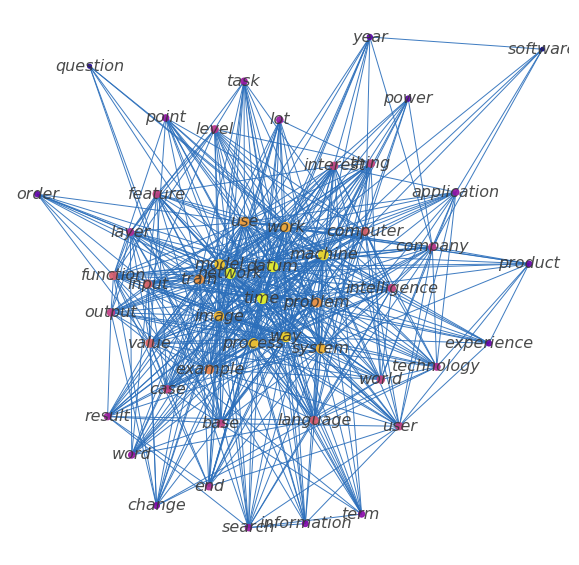

In [80]:
# Visualization
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

#### Stretch - Ego-Network

In [81]:
g_n = gNN.subgraph(['datum'] + list(gNN.neighbors('datum')))
print(nx.info(g_n))

Name: 
Type: Graph
Number of nodes: 47
Number of edges: 578
Average degree:  24.5957


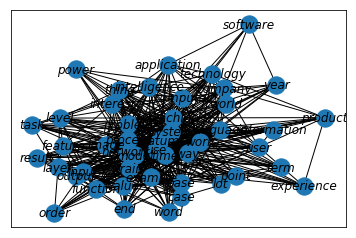

In [82]:
nx.draw_networkx(g_n)

In [83]:
# Neighbors of "feature"
pointNeighbors = gNN.neighbors('feature')
set(pointNeighbors)

{'case',
 'datum',
 'example',
 'feature',
 'function',
 'image',
 'input',
 'interest',
 'layer',
 'level',
 'machine',
 'model',
 'network',
 'output',
 'process',
 'time',
 'train',
 'use',
 'way',
 'work'}

In [84]:
pointNeighbors = set(gNN.neighbors('feature'))
pointNeighborsPlus1 = set(pointNeighbors)
for n in pointNeighbors:
    pointNeighborsPlus1 |= set(gNN.neighbors(n))

In [87]:
gNN_feature = gNN.subgraph(pointNeighborsPlus1)
print(nx.info(gNN_feature))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 615
Average degree:  24.6000


In [88]:
# Degree centrality
sorted(nx.degree_centrality(gNN_feature).items(), key = lambda x: x[1], reverse = True)[:10]

[('network', 0.9795918367346939),
 ('datum', 0.9795918367346939),
 ('time', 0.9795918367346939),
 ('machine', 0.9387755102040816),
 ('way', 0.8775510204081632),
 ('model', 0.8775510204081632),
 ('process', 0.8163265306122448),
 ('work', 0.7959183673469387),
 ('image', 0.7959183673469387),
 ('system', 0.7959183673469387)]

In [89]:
# Eigenvector centrality
sorted(nx.eigenvector_centrality(gNN_feature).items(), key = lambda x: x[1], reverse = True)[:10]

[('network', 0.22879296624499254),
 ('time', 0.227948949497609),
 ('datum', 0.2269620445026693),
 ('machine', 0.21578338148767062),
 ('way', 0.21237053638201192),
 ('model', 0.20744206114051328),
 ('process', 0.20507129346686861),
 ('image', 0.19996031412170548),
 ('system', 0.19780900820239702),
 ('work', 0.1933054518816379)]

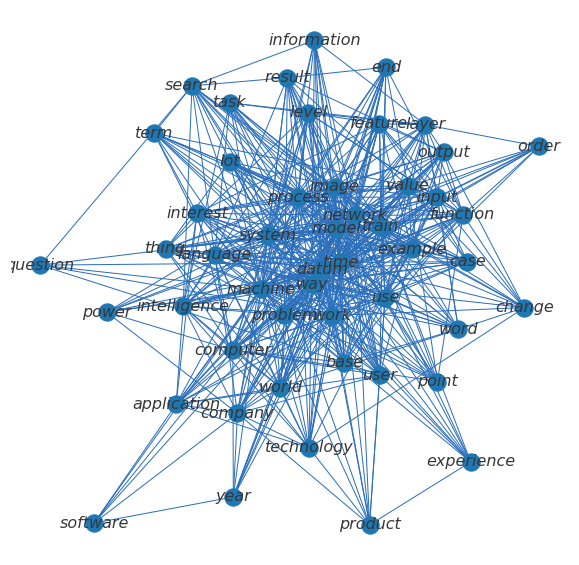

In [90]:
layout_point = nx.spring_layout(gNN_point, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNN_point, ax = ax, pos = layout_point, labels = {n: n for n in gNN_feature.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

### Noun-Verb Network

In [92]:
gNV = posCooccurrence(medium_df['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 5772
Number of edges: 148222
Average degree:  51.3590


In [93]:
# Remove co-occurrence between nouns and nouns as well as verbs and verbs
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 5772
Number of edges: 31699
Average degree:  10.9837


In [94]:
# Drop low weight edges and low degree vertices
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 10])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 25])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 30
Average degree:   5.4545


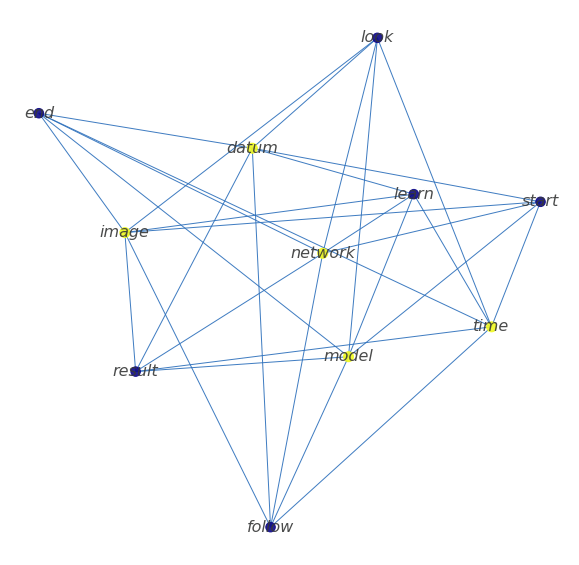

In [95]:
layout_nv = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nv, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

#### Stretch - Ego-Network

In [96]:
g_i = gNV.subgraph(['network'] + list(gNV.neighbors('network')))
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 6
Average degree:   1.7143


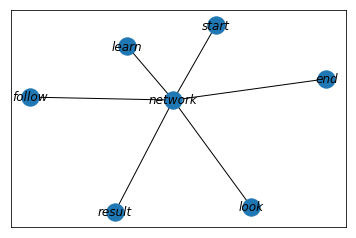

In [97]:
nx.draw_networkx(g_i)

In [99]:
# Neighbors of "result"
resultNeighbors = gNV.neighbors('result')
set(resultNeighbors)

{'datum', 'image', 'model', 'network', 'time'}

In [100]:
resultNeighbors= set(gNV.neighbors('result'))
resultNeighborsPlus1 = set(resultNeighbors)
for n in resultNeighbors:
    resultNeighborsPlus1 |= set(gNV.neighbors(n))
gNV_result = gNV.subgraph(resultNeighborsPlus1)
print(nx.info(gNV_result))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 30
Average degree:   5.4545


In [101]:
# Degree centrality
sorted(nx.degree_centrality(gNV_result).items(), key = lambda x: x[1], reverse = True)[:10]

[('network', 0.6000000000000001),
 ('datum', 0.6000000000000001),
 ('time', 0.6000000000000001),
 ('image', 0.6000000000000001),
 ('model', 0.6000000000000001),
 ('look', 0.5),
 ('follow', 0.5),
 ('result', 0.5),
 ('start', 0.5),
 ('learn', 0.5)]

In [102]:
# Eigenvector centrality
sorted(nx.eigenvector_centrality(gNV_result).items(), key = lambda x: x[1], reverse = True)[:10]

[('network', 0.316228087720391),
 ('datum', 0.316228087720391),
 ('time', 0.316228087720391),
 ('image', 0.316228087720391),
 ('model', 0.316228087720391),
 ('look', 0.2886748409206927),
 ('follow', 0.2886748409206927),
 ('result', 0.2886748409206927),
 ('start', 0.2886748409206927),
 ('learn', 0.2886748409206927)]

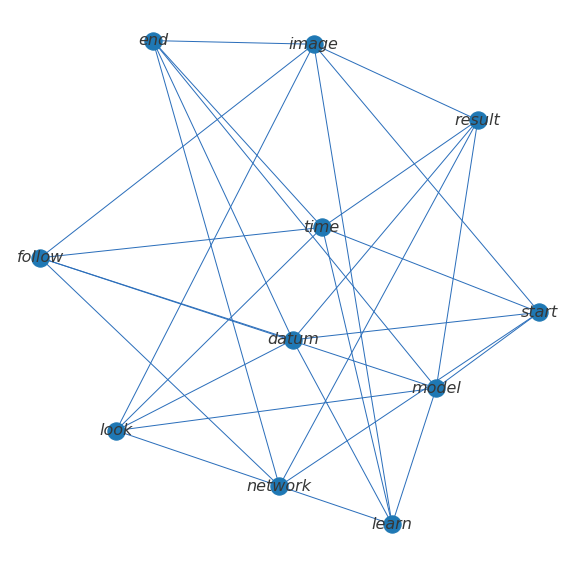

In [103]:
# Visualization
layout_result = nx.spring_layout(gNV_result, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_result, ax = ax, pos = layout_result, labels = {n: n for n in gNV_result.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

### Noun-Adjective Network

In [104]:
gNJ = posCooccurrence(medium_df['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 4309
Number of edges: 95282
Average degree:  44.2246


In [105]:
# Remove low weight edges and low frequency nodes
gNJ.remove_nodes_from([n for n in gNJ.nodes if len(set(gNJ.neighbors(n))) <= 600])
gNJ.remove_edges_from([(n1, n2) for n1, n2, d in gNJ.edges(data = True) if d['weight'] <= 10])
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 104
Average degree:  12.2353


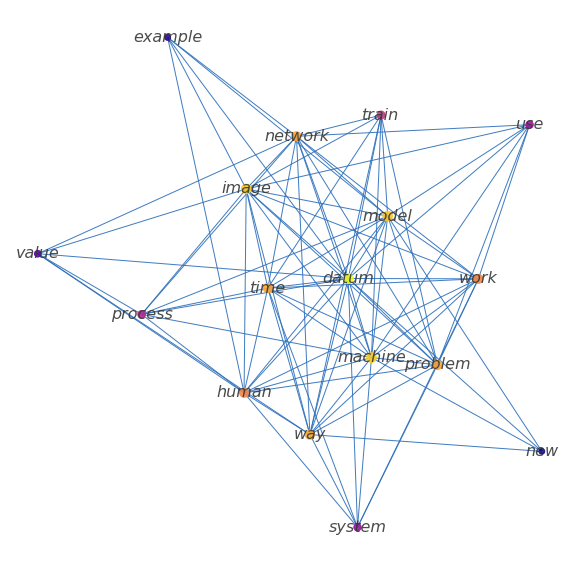

In [106]:
layout_nj = nx.spring_layout(gNJ, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj = nx.eigenvector_centrality(gNJ)
maxC = max(centralities_nj.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNJ.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNJ.edges(data = True)))
nx.draw(gNJ, ax = ax, pos = layout_nj, labels = {n: n for n in gNJ.nodes()}, 
        alpha = .9, 
        node_color = [centralities_nj[n] / maxC for n in gNJ.nodes],
        node_size = [centralities_nj[n] / maxC * 100 for n in gNJ.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

#### Stretch - Ego-Network

In [107]:
g_j = gNJ.subgraph(['time'] + list(gNJ.neighbors('time')))
print(nx.info(g_j))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 79
Average degree:  12.1538


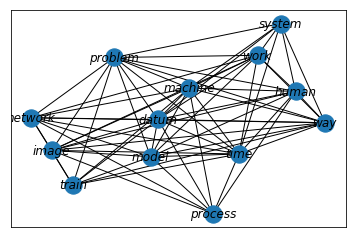

In [108]:
nx.draw_networkx(g_j)

In [109]:
# Neighbors of "work"
workNeighbors = gNJ.neighbors('work')
set(workNeighbors)

{'datum',
 'human',
 'image',
 'machine',
 'model',
 'network',
 'problem',
 'system',
 'time',
 'use',
 'way',
 'work'}

In [110]:
workNeighbors = set(gNJ.neighbors('work'))
workNeighborsPlus1 = set(workNeighbors)
for n in workNeighbors:
    workNeighborsPlus1 |= set(gNJ.neighbors(n))
gNJ_work = gNJ.subgraph(workNeighborsPlus1)
print(nx.info(gNJ_work))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 104
Average degree:  12.2353


In [111]:
# Degree centrality
sorted(nx.degree_centrality(gNJ_work).items(), key = lambda x: x[1], reverse = True)[:10]

[('datum', 1.125),
 ('image', 1.0),
 ('machine', 1.0),
 ('model', 1.0),
 ('network', 0.9375),
 ('way', 0.9375),
 ('time', 0.875),
 ('human', 0.875),
 ('problem', 0.875),
 ('work', 0.8125)]

In [112]:
# Eigenvector centrality
sorted(nx.eigenvector_centrality(gNJ_work).items(), key = lambda x: x[1], reverse = True)[:10]

[('datum', 0.32121915875166596),
 ('machine', 0.3000272581619818),
 ('image', 0.298534935566048),
 ('model', 0.29545116897369667),
 ('way', 0.2816442512527733),
 ('network', 0.27753926361280556),
 ('time', 0.2769574834968675),
 ('problem', 0.27592396371710887),
 ('work', 0.2592826532045864),
 ('human', 0.2590104488148937)]

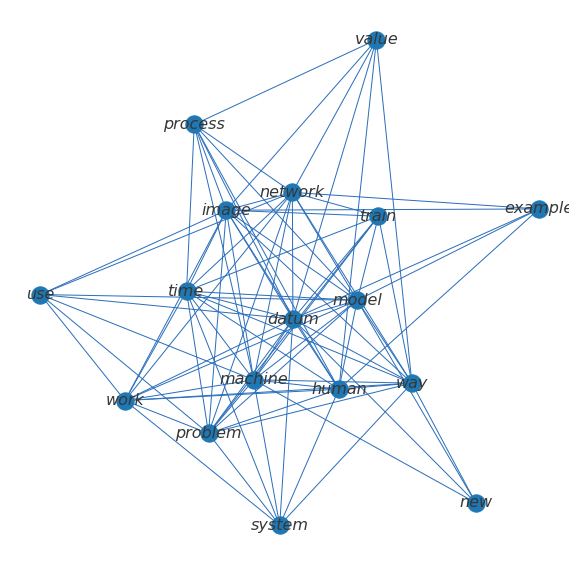

In [113]:
# Visualization
layout_work = nx.spring_layout(gNJ_work, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNJ_work, ax = ax, pos = layout_work, labels = {n: n for n in gNJ_work.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

According to the network graphs, either in the noun-noun network, noun-vern network or in the noun-adjective network, the words such as 'machine', 'model', 'netwrok' are always the most central words in the network. I also draw the ego-networks for 'datum', 'result', 'work' and so on. They are helpful to identify common combinations of these words. For instance, from the result above, we can find that 'search', 'add', 'try', 'learn', 'start' are quite commonly connected with the noun 'network', which in lines with our common sense.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

For this part of the assignment, because my project does not involove in much interactions, I will also use the soup copora, but they are extracted from different soaps compared to examples presented above.

In [117]:
corpora_address = "/Users/gaomingtao/Desktop/MACS 60000/Homework-Notebooks/week-5/SOAP"
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [118]:
import zipfile
import pandas as pd
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [119]:
soap_dict = {}
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [120]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [122]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
i = 0
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1
soap_df.head()

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


Soap Name                                    Tokenized Texts
0      All My Childen  [@!Reporter, Is, there, anything, you, regret,...
1  As the World Turns  [@!Katie, Okay, I, know, these, words, are, lo...
2  Bold and Beautiful  [@!Bridget, What, did, you, say, @!Deacon, Jus...
3   Days of Our Lives  [@!Maggie, How, are, you, doing, @!Victor, Fin...
4    General Hospital  [@!Luke, I, signed, my, divorce, papers, You, ...

For my assignment, I will conduct my analysis on a different soap: "Bold and Beautiful"

In [123]:
dool = soap_df['Tokenized Texts'][2]
' '.join(dool[0:1500])
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
len(characters)

613

In [124]:
# Keep the characters with a high number of appearances
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Bridget 2181
Brooke 4706
Stephanie 3098
Ridge 3314
Nick 2651


In [125]:
# Create the actor network
actor_network = nx.Graph()
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [126]:
actor_network.nodes.data()

NodeDataView({'Bridget': {'lines_spoken': 2181, 'words': []}, 'Brooke': {'lines_spoken': 4706, 'words': []}, 'Stephanie': {'lines_spoken': 3098, 'words': []}, 'Ridge': {'lines_spoken': 3314, 'words': []}, 'Nick': {'lines_spoken': 2651, 'words': []}})

In [127]:
# Create the network graph
i = 0
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

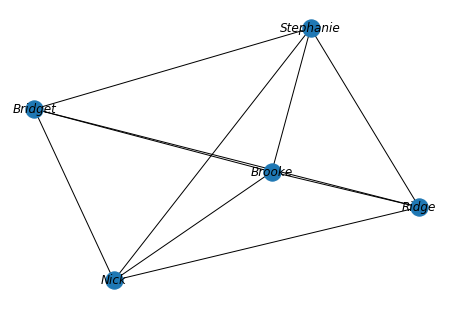

In [128]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

The network above shows that Brooke is the center of this network.

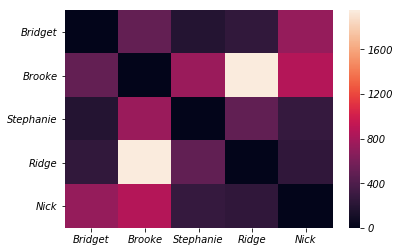

In [129]:
import seaborn as sns

L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [130]:
c = list(greedy_modularity_communities(actor_network))
c

[frozenset({'Bridget', 'Brooke', 'Nick', 'Ridge', 'Stephanie'})]

In [131]:
smaller_actor_network = nx.Graph()
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 480:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])

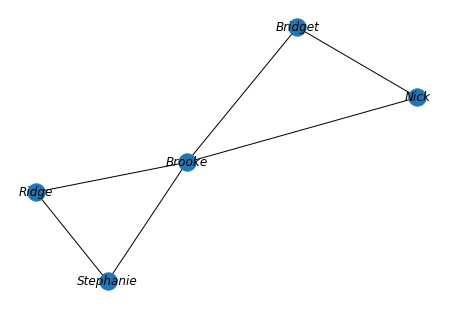

In [132]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

In [133]:
c = list(greedy_modularity_communities(smaller_actor_network))
c

[frozenset({'Bridget', 'Brooke', 'Nick', 'Ridge', 'Stephanie'})]

In [135]:
# Degree centrality
dcentralities = nx.degree_centrality(smaller_actor_network)
dcentralities['Brooke']

1.0

Brooke is clearly the center of this opera as other actors are linked through her. High centrality indicates her influence and importance in the show.

In [136]:
# Function from previous homeworks 
import nltk

def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [138]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

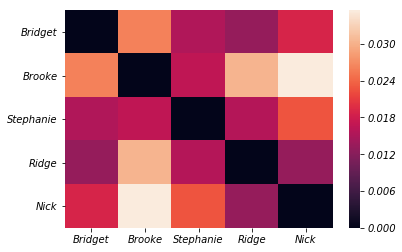

In [139]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

The last heatmap we generated indicates most interactions happened between Brooke and Ridge. This heatmap reveals a different result, that Brooke and Nick have more interactions.